# Configuration

In [ ]:
!pip uninstall tensorflow-gpu
!pip install -q tensorflow-gpu==2.1.0-rc1


     |████████████████████████████████| 421.8MB 16kB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 3.9MB 28.4MB/s 
     |████████████████████████████████| 450kB 37.9MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

import numpy as np
import collections

import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print(tf.__version__)


2.1.0-rc1


In [ ]:
MEASURE_INTERVAL = 5
SAMPLING = int(30 / MEASURE_INTERVAL)
INPUT_WINDOW_SIZE = int(5 * 60 / MEASURE_INTERVAL / SAMPLING)
GROUND_TRUTH_INDEX = int(2 * 60 / MEASURE_INTERVAL / SAMPLING)
CLASS_NUMBER = 2

TRAIN_EPOCH = 1000
TRAIN_TEST_RATIO = 0.2
TRAIN_VALIDATION_RATIO = 0.25

# Util Function

In [ ]:
def load_data(fileList):
  resultX = []
  resultY = []

  for fileName in fileList:
    tempX = []
    tempY = []
    fp = open(fileName+'.csv', 'r')
    while True:
      line = fp.readline()
      if not line: break
      temp = line.split('\n')[0]
      temp = temp.split(',')
      tempX.append(np.array(temp[0:4]))
      tempY.extend(temp[4:5])
    
    for i in range(len(tempX) - (INPUT_WINDOW_SIZE * SAMPLING)):
      x = []
      for j in range(INPUT_WINDOW_SIZE):
        x.append(tempX[i + SAMPLING * j][:])
      resultX.append(x)
    resultY.extend(tempY[GROUND_TRUTH_INDEX * SAMPLING : len(tempY) - (INPUT_WINDOW_SIZE - GROUND_TRUTH_INDEX) * SAMPLING])
  
  transY = []
  for trans in resultY:
    transTemp = np.int(trans)
    if transTemp == 1:
      transY.append(0)
    elif transTemp == 3 or transTemp == 2:
      transY.append(1)
    else:
      transY.append(0)

  resultX = np.array(resultX, dtype=np.float32)
  resultY = np.array(transY, dtype=np.int32)
  return resultX.reshape((len(resultX), INPUT_WINDOW_SIZE, 4, 1)), resultY

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fsize=(10,10)):
  plt.figure(figsize=fsize)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
  	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    con_mat_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    con_mat_norm = np.around(con_mat_norm, decimals=2)
    plt.text(j, i,con_mat_norm[i,j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


In [ ]:
def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(8,5))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color='red',
             label=name.title()+' Train')
    
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

# Load Dataset

In [ ]:
datasetFileList = ["dataset1_fre_labeled", "dataset2_fre_labeled", "dataset3_fre_labeled", "dataset4_fre_labeled"]
#datasetFileList = ["dataset4_fre_labeled_1"]

X, Y = load_data(datasetFileList)
print(X.shape, Y.shape)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=TRAIN_TEST_RATIO, shuffle=True, random_state=1004)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=TRAIN_VALIDATION_RATIO, shuffle=True, random_state=1004)

(3383, 10, 4, 1) (3383,)


In [ ]:
collections.Counter(trainY)

Counter({0: 1825, 1: 204})

# Multi Layer Perceptron

In [ ]:
print("train set: "+str(len(trainX)))
print("test set: "+str(len(testY)))

train set: 2029
test set: 677


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 10, 4, 32)         320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 5, 4, 32)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 5, 4, 32)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 5, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 2, 4, 16)          0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 2, 4, 16)          0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 2, 4, 16)        

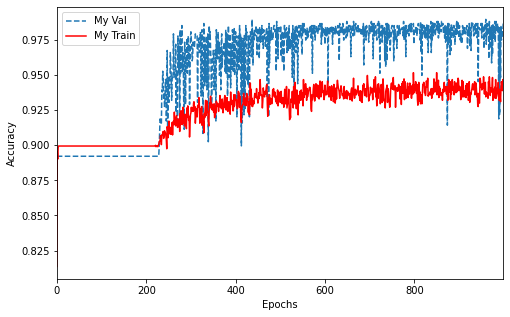

In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(INPUT_WINDOW_SIZE, 4, 1)),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(CLASS_NUMBER, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

myHistory = model.fit(trainX, trainY, epochs=TRAIN_EPOCH, verbose=0,
                      batch_size=256, validation_data=(valX, valY))

plot_history([('my', myHistory)])

Y_pred = model.predict(testX)

Y_pred_classes = np.argmax(Y_pred, axis = 1)

              precision    recall  f1-score   support

           0    0.98691   0.98691   0.98691       611
           1    0.87879   0.87879   0.87879        66

    accuracy                        0.97637       677
   macro avg    0.93285   0.93285   0.93285       677
weighted avg    0.97637   0.97637   0.97637       677



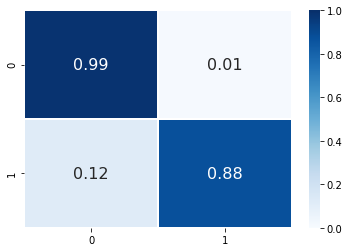

In [ ]:
confusion_mtx = confusion_matrix(testY, Y_pred_classes)

plt.subplots(figsize=(6,4))
sns.heatmap((confusion_mtx/np.bincount(testY)[:, np.newaxis]), annot=True, fmt='0.2f', vmin=0, vmax=1, annot_kws={'size':16}, linewidths=.5, cmap='Blues')

print(metrics.classification_report(testY, Y_pred_classes, digits=5))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 10, 4, 64)         640       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 5, 4, 64)          0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 5, 4, 64)          0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 5, 4, 32)          18464     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 2, 4, 32)          0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 2, 4, 32)          0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 2, 4, 16)        

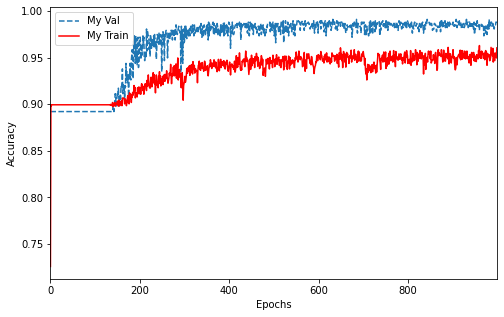

In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(INPUT_WINDOW_SIZE, 4, 1)),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(CLASS_NUMBER, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

myHistory = model.fit(trainX, trainY, epochs=TRAIN_EPOCH, verbose=0,
                      batch_size=256, validation_data=(valX, valY))

plot_history([('my', myHistory)])

Y_pred = model.predict(testX)

Y_pred_classes = np.argmax(Y_pred, axis = 1)

              precision    recall  f1-score   support

           0    0.99013   0.98527   0.98769       611
           1    0.86957   0.90909   0.88889        66

    accuracy                        0.97784       677
   macro avg    0.92985   0.94718   0.93829       677
weighted avg    0.97838   0.97784   0.97806       677



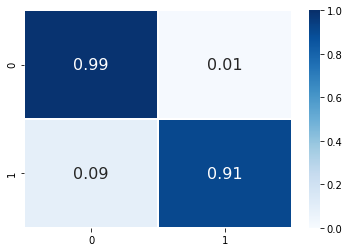

In [ ]:
confusion_mtx = confusion_matrix(testY, Y_pred_classes)

plt.subplots(figsize=(6,4))
sns.heatmap((confusion_mtx/np.bincount(testY)[:, np.newaxis]), annot=True, fmt='0.2f', vmin=0, vmax=1, annot_kws={'size':16}, linewidths=.5, cmap='Blues')

print(metrics.classification_report(testY, Y_pred_classes, digits=5))

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 10, 4, 128)        1280      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 5, 4, 128)         0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 5, 4, 128)         0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 5, 4, 64)          73792     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 2, 4, 64)          0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 2, 4, 64)          0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 2, 4, 32)        

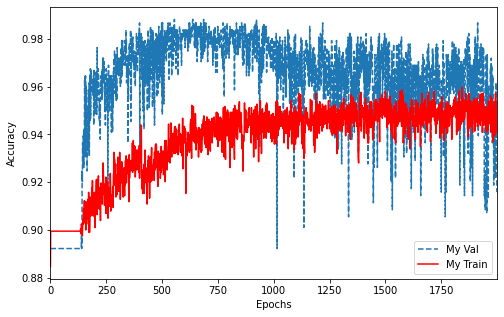

In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(INPUT_WINDOW_SIZE, 4, 1)),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D((2, 1)),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(CLASS_NUMBER, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

myHistory = model.fit(trainX, trainY, epochs=TRAIN_EPOCH*2, verbose=0,
                      batch_size=256, validation_data=(valX, valY))

plot_history([('my', myHistory)])

Y_pred = model.predict(testX)

Y_pred_classes = np.argmax(Y_pred, axis = 1)

              precision    recall  f1-score   support

           0    0.92998   1.00000   0.96372       611
           1    1.00000   0.30303   0.46512        66

    accuracy                        0.93205       677
   macro avg    0.96499   0.65152   0.71442       677
weighted avg    0.93681   0.93205   0.91511       677



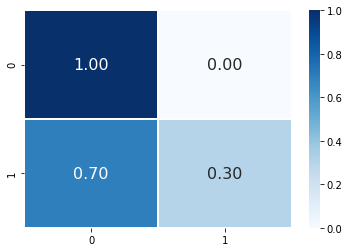

In [ ]:
confusion_mtx = confusion_matrix(testY, Y_pred_classes)

plt.subplots(figsize=(6,4))
sns.heatmap((confusion_mtx/np.bincount(testY)[:, np.newaxis]), annot=True, fmt='0.2f', vmin=0, vmax=1, annot_kws={'size':16}, linewidths=.5, cmap='Blues')

print(metrics.classification_report(testY, Y_pred_classes, digits=5))